In [1]:
from vertica_utils_2 import *
import time
import pandas as pd
import matplotlib.pyplot as plt
import ipaddress
from datetime import timedelta
import hashlib

Flow del script: 
1. Carga de datos
2. Limpieza de requests que no representan navegacion (sólo son recursos de la web)
3. Generar sesiones de "navegacion" con umbral de inactividad de 30 mins

In [2]:
def generar_hash_visitante(ip, ua):
    raw = f"{ip}_{ua}"
    return hashlib.md5(raw.encode()).hexdigest()

### 1. Carga de datos

In [3]:
conn_info = {'host': '194.30.35.48',
        'port': 5433,
        'user': 'dbadmin',
        'password': 'dsd&PL70@!#v',
        'session_label': 'vertica_session',
        'unicode_error': 'strict',
        'ssl': False,
        'autocommit': True,
        'use_prepared_statements': False,
        'connection_timeout': 50}

In [5]:
query_OP = "SELECT * FROM LogAnalysis.CORDIS_Logs LIMIT 500000"
data = select_query_vertica(conn_info, query_OP)

### 2. Limpieza

In [6]:
excluir_extensiones = ('.css', '.js', '.png', '.jpg', '.jpeg', '.svg', '.ico', '.woff', '.woff2', '.ttf', '.eot', '.map', '.gif', '.json')

In [7]:
data = data[~data['request_uri'].str.lower().str.endswith(excluir_extensiones)]

In [8]:
print(len(data))

200524


### 3. Sesiones

In [9]:
data['time_local'] = pd.to_datetime(data['time_local'])

data['visitor_id'] = data.apply(lambda row: generar_hash_visitante(row['remote_addr'], row['http_user_agent']), axis=1)

# Ordenar los datos por visitante y por hora
data = data.sort_values(by=['visitor_id', 'time_local'])

# Definir el umbral de corte de sesión (30 minutos)
umbral_inactividad = timedelta(minutes=30)

In [10]:
data['nueva_sesion'] = (
    data.groupby('visitor_id')['time_local']
    .diff()
    .gt(umbral_inactividad)
    .fillna(True)
)

# Numerar sesiones por visitante
data['session_number'] = data.groupby('visitor_id')['nueva_sesion'].cumsum()

# Crear identificador global de sesión
data['session_id'] = data['visitor_id'] + "_s" + data['session_number'].astype(str)

In [11]:
print(len(data['session_id'].unique()))

27204


#### Es decir, de los medio millon de request inicial, se nos quedan en 27.204 sesiones

In [16]:
data.columns

Index(['msec', 'connection', 'connection_requests', 'pid', 'request_id',
       'request_length', 'remote_addr', 'remote_user', 'remote_port',
       'time_local', 'time_iso8601', 'request', 'request_uri', 'args',
       'status', 'body_bytes_sent', 'bytes_sent', 'http_referer',
       'http_user_agent', 'http_x_forwarded_for', 'http_host', 'server_name',
       'request_time', 'upstream', 'upstream_connect_time',
       'upstream_header_time', 'upstream_response_time',
       'upstream_response_length', 'upstream_cache_status', 'ssl_protocol',
       'ssl_cipher', 'scheme', 'request_method', 'server_protocol', 'pipe',
       'gzip_ratio', 'http_cf_ray', 'geoip_country_code', 'timestamp',
       'visitor_id', 'nueva_sesion', 'session_number', 'session_id'],
      dtype='object')

In [22]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Ordenamos por sesión y tiempo
data = data.sort_values(['session_id', 'timestamp'])

# Calculamos la diferencia de tiempo entre requests consecutivos por sesión
data['inter_request_time'] = data.groupby('session_id')['timestamp'].diff().dt.total_seconds()

# Agrupamos por session_id
session_stats = data.groupby('session_id').agg(
    visitor_id=('visitor_id', 'first'),
    session_number=('session_number', 'first'),
    remote_addr=('remote_addr', 'first'),
    http_user_agent=('http_user_agent', 'first'),
    n_requests=('request_id', 'count'),
    n_unique_requests=('request_uri', 'nunique'),
    session_start=('timestamp', 'min'),
    session_end=('timestamp', 'max'),
    inter_request_time_avg=('inter_request_time', lambda x: x[1:].mean()),
    inter_request_time_std=('inter_request_time', lambda x: x[1:].std())
).reset_index()

# Calcular duración en segundos
session_stats['duration_seconds'] = (session_stats['session_end'] - session_stats['session_start']).dt.total_seconds()

# Calcular frecuencia: requests por segundo
session_stats['reqs_per_second'] = session_stats.apply(
    lambda row: row['n_requests'] / row['duration_seconds'] if row['duration_seconds'] > 0 else 0,
    axis=1
)

In [23]:
session_stats

,session_id,visitor_id,session_number,remote_addr,http_user_agent,n_requests,n_unique_requests,session_start,session_end,inter_request_time_avg,inter_request_time_std,duration_seconds,reqs_per_second
0,0008fd36e088856e4dff6c345447be51_s0,0008fd36e088856e4dff6c345447be51,0,184.174.6.69,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:15.0) G...,1,1,2025-03-20 16:10:50.897057,2025-03-20 16:10:50.897057,NaN,NaN,0.000000,0.000000
1,000e89b3ea0ce67bca5e9f26a0405dfd_s0,000e89b3ea0ce67bca5e9f26a0405dfd,0,220.181.108.113,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,7,7,2025-03-20 16:09:56.409985,2025-03-20 16:10:07.283212,1.812204,1.887088,10.873227,0.643783
2,000e89b3ea0ce67bca5e9f26a0405dfd_s1,000e89b3ea0ce67bca5e9f26a0405dfd,1,220.181.108.113,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,1,1,2025-03-20 16:10:50.897057,2025-03-20 16:10:50.897057,NaN,NaN,0.000000,0.000000
3,000e89b3ea0ce67bca5e9f26a0405dfd_s2,000e89b3ea0ce67bca5e9f26a0405dfd,2,220.181.108.113,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,3,3,2025-03-20 16:10:59.472139,2025-03-20 16:11:01.573574,1.050717,1.485939,2.101435,1.427596
4,000e89b3ea0ce67bca5e9f26a0405dfd_s3,000e89b3ea0ce67bca5e9f26a0405dfd,3,220.181.108.113,Mozilla/5.0 (compatible; Baiduspider/2.0; +htt...,1,1,2025-03-20 16:11:07.914198,2025-03-20 16:11:07.914198,NaN,NaN,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27199,fff707af8d54d14bdce54dea700e8b88_s1,fff707af8d54d14bdce54dea700e8b88,1,17.241.227.151,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1,1,2025-03-20 16:10:57.417644,2025-03-20 16:10:57.417644,NaN,NaN,0.000000,0.000000
27200,fff707af8d54d14bdce54dea700e8b88_s2,fff707af8d54d14bdce54dea700e8b88,2,17.241.227.151,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,3,3,2025-03-20 16:11:04.768116,2025-03-20 16:11:04.768116,0.000000,0.000000,0.000000,0.000000
27201,fff707af8d54d14bdce54dea700e8b88_s3,fff707af8d54d14bdce54dea700e8b88,3,17.241.227.151,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,6,6,2025-03-20 16:11:45.118469,2025-03-20 16:12:03.707416,3.717789,2.478640,18.588947,0.322772
27202,fffc9f5acfb244e9ac0197ff7bae03f9_s0,fffc9f5acfb244e9ac0197ff7bae03f9,0,152.53.112.132,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,2,1,2025-03-20 16:12:06.204130,2025-03-20 16:12:06.204130,0.000000,NaN,0.000000,0.000000


In [25]:
import matplotlib.pyplot as plt
import itertools

In [27]:
# Lista de columnas numéricas que quieres cruzar
cols_numericas = [
    'n_requests',
    'n_unique_requests',
    'duration_seconds',
    'reqs_per_second',
    'inter_request_time_avg',
    'inter_request_time_std'
]

In [29]:
session_stats[cols_numericas].describe()

,n_requests,n_unique_requests,duration_seconds,reqs_per_second,inter_request_time_avg,inter_request_time_std
count,27204.000000,27204.000000,27204.000000,27204.000000,14022.000000,8778.000000
mean,7.371122,5.791097,2.773034,0.817144,1.349927,1.319103
std,77.152061,56.674586,5.780984,16.410525,1.754016,1.217128
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.245779
50%,2.000000,1.000000,0.000000,0.000000,0.698729,1.118544
75%,3.000000,3.000000,3.208200,0.471945,2.116799,2.079177
max,6143.000000,5702.000000,38.248212,1857.298207,10.873227,7.188441


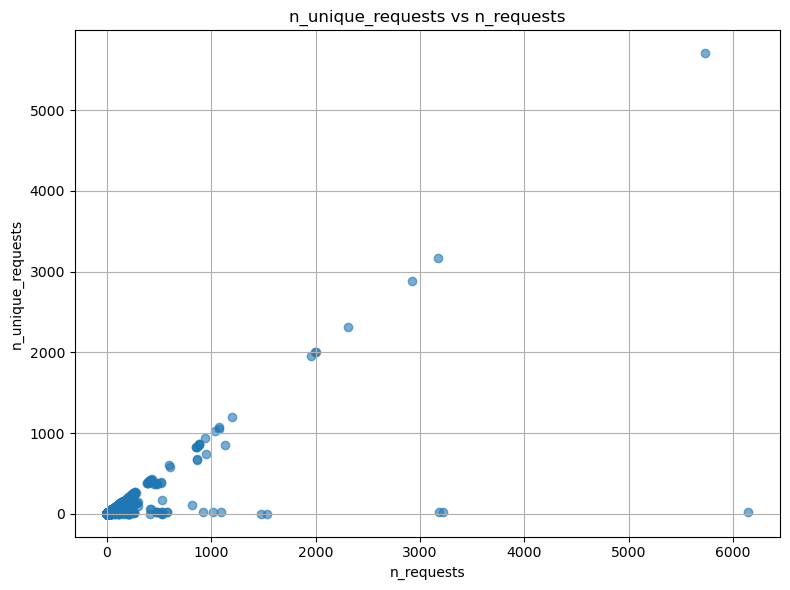

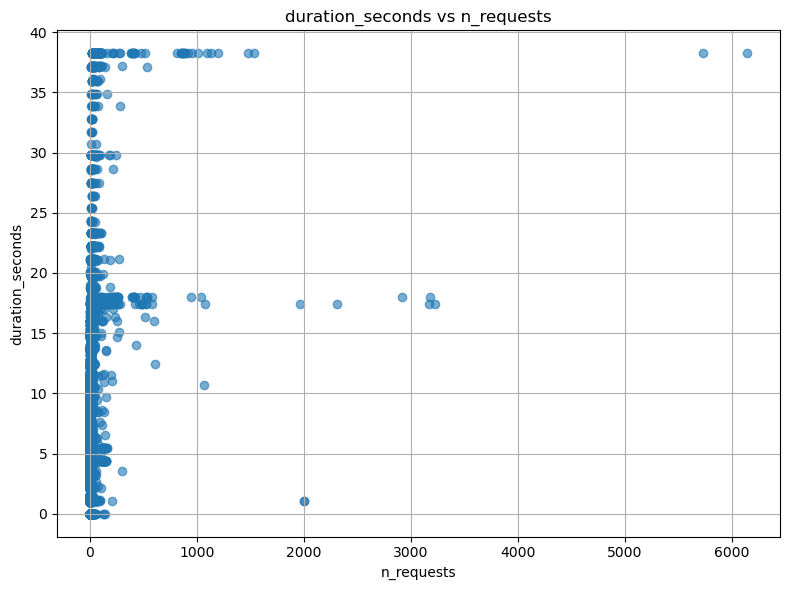

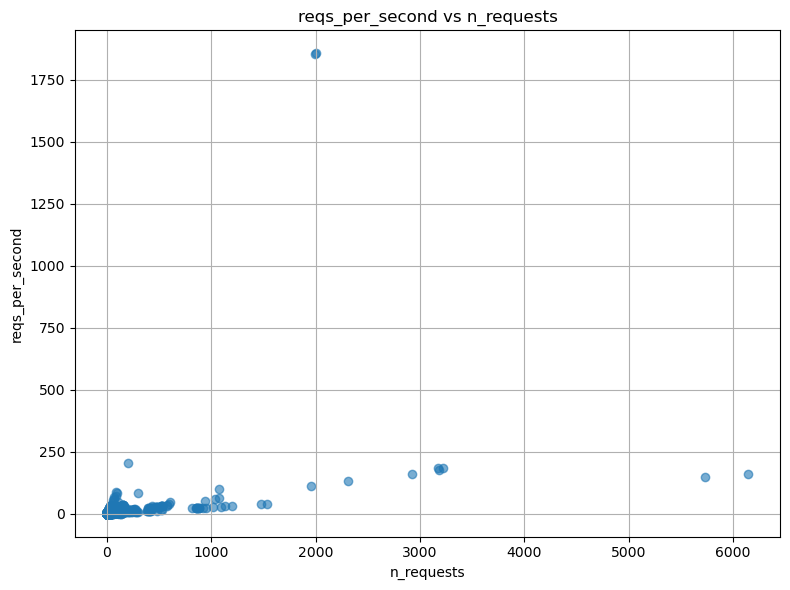

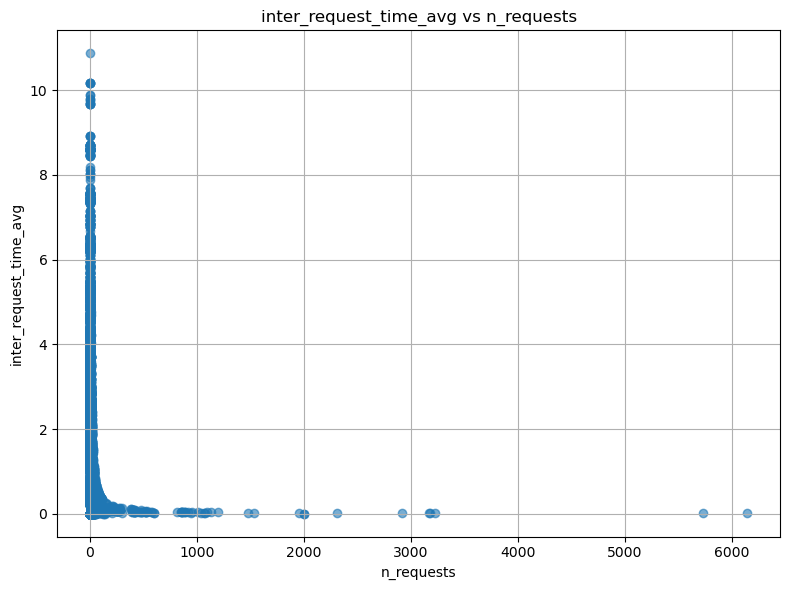

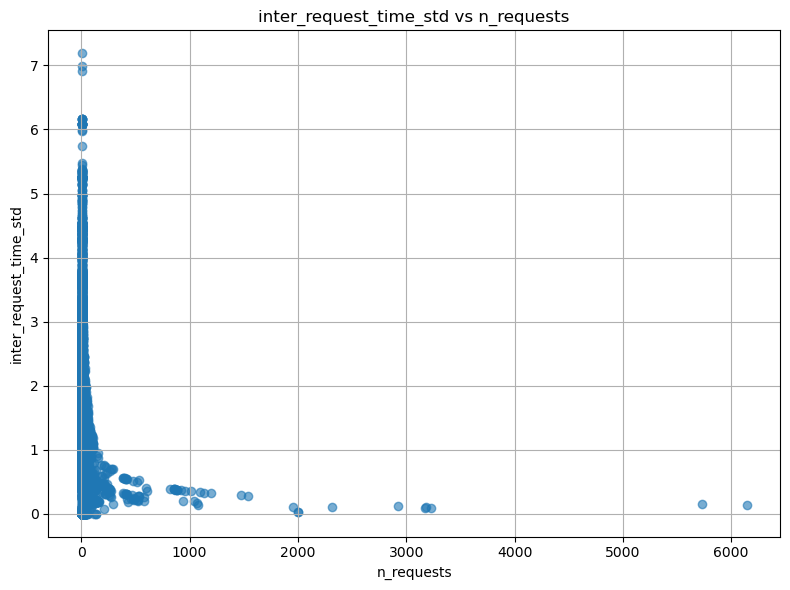

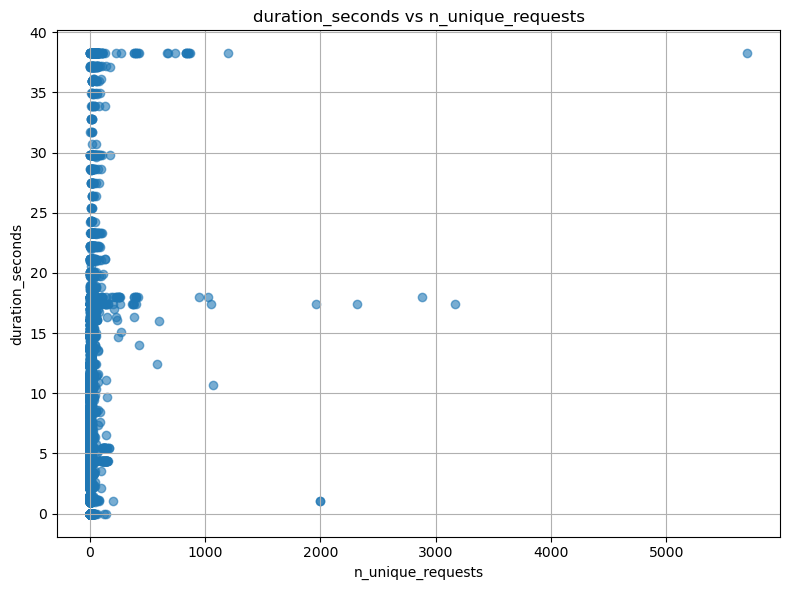

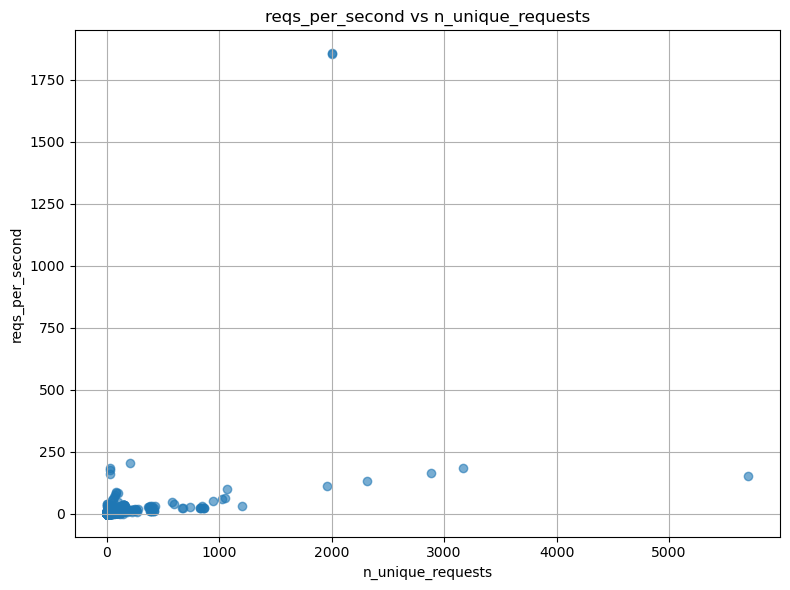

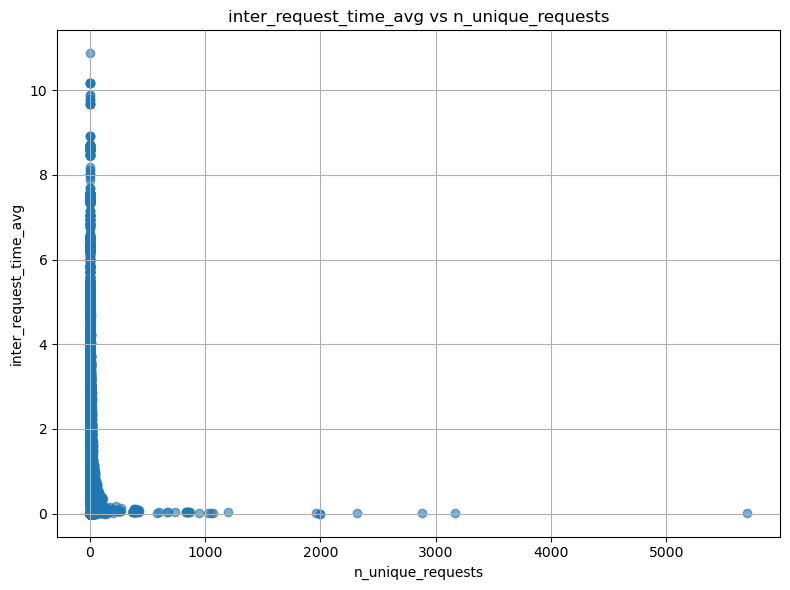

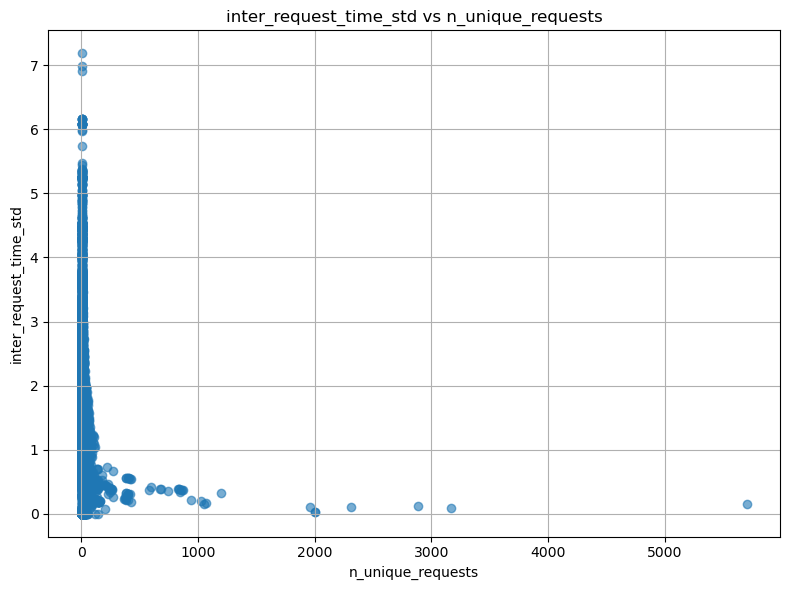

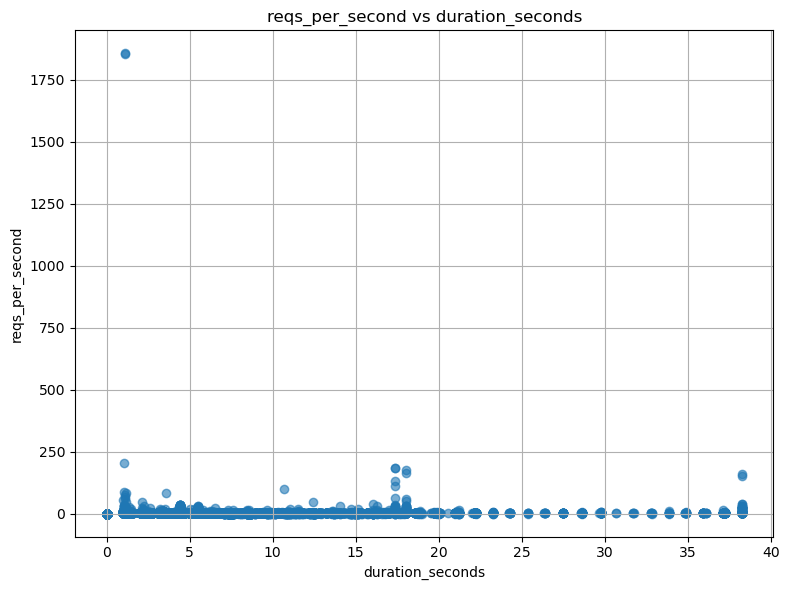

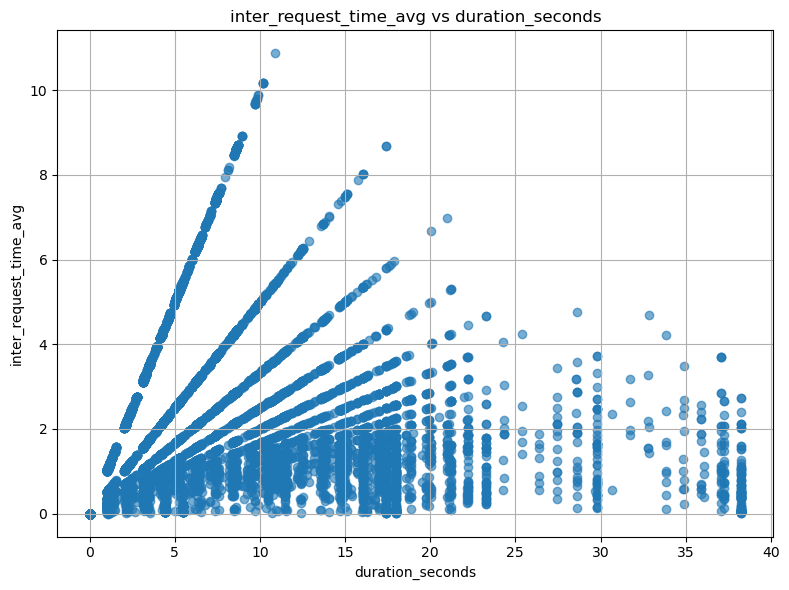

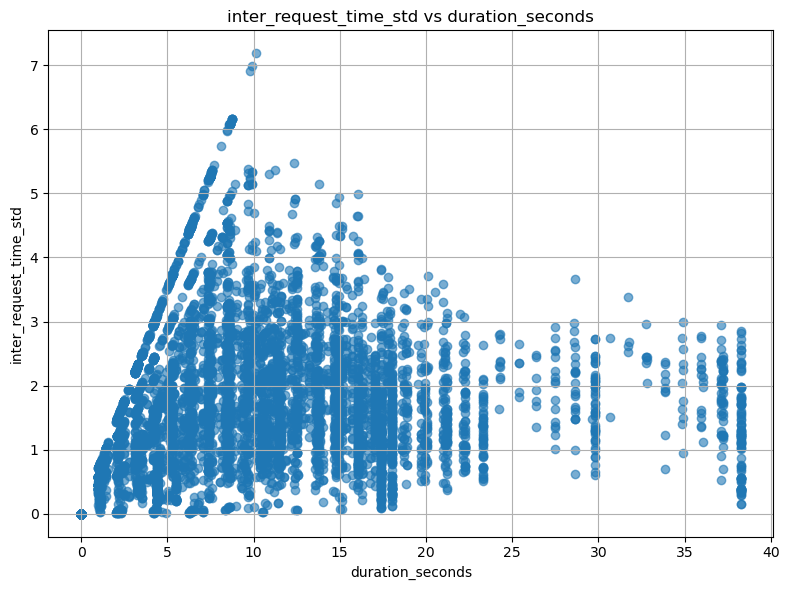

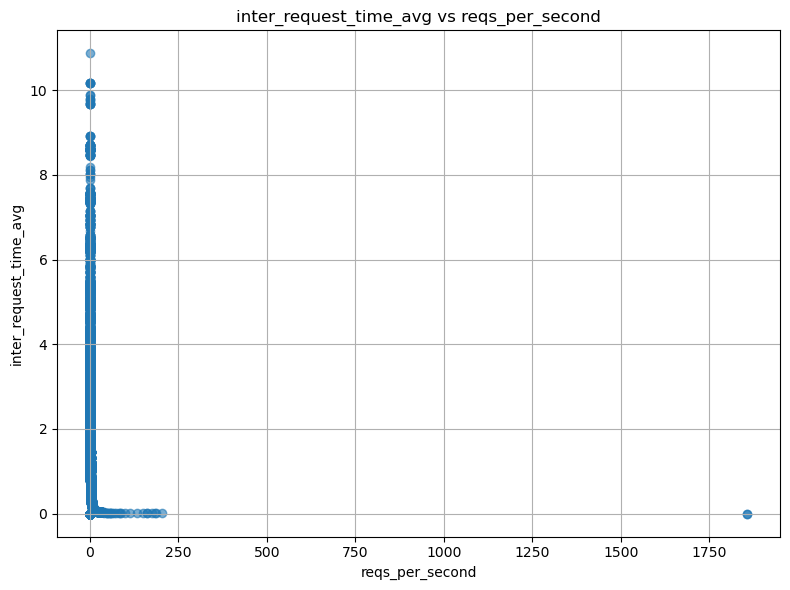

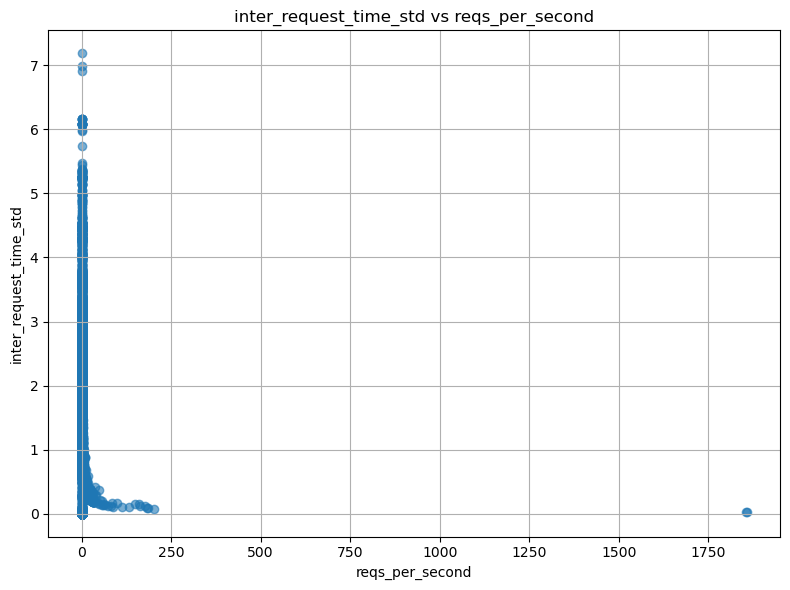

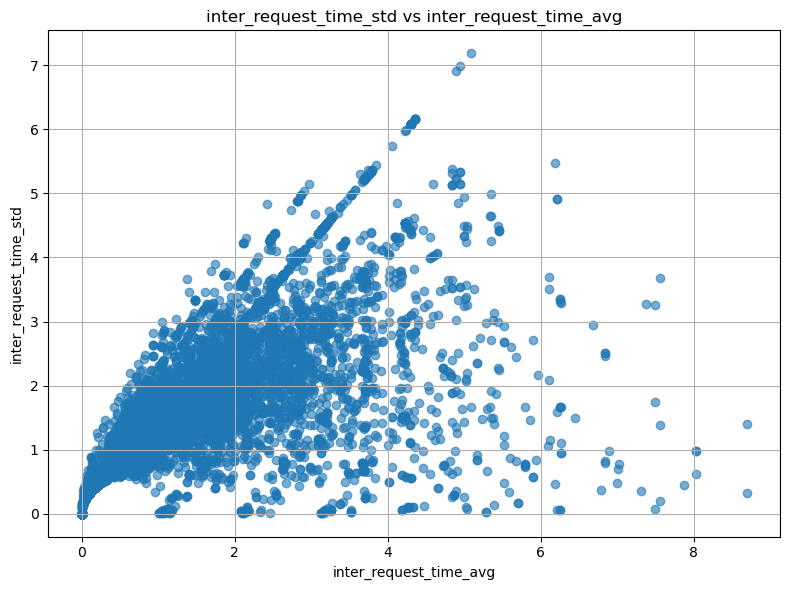

In [26]:
# Creamos todas las combinaciones posibles de columnas de dos en dos
combinaciones = list(itertools.combinations(cols_numericas, 2))

# Dibujamos cada combinación por separado
for x_col, y_col in combinaciones:
    plt.figure(figsize=(8, 6))
    plt.scatter(session_stats[x_col], session_stats[y_col], alpha=0.6)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{y_col} vs {x_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Sobre esto, vamos a ver como se comportan los bots

In [ ]:
# === 1. Diccionario con los rangos de IP por tipo de bot ===
bot_ip_ranges = {
    "SearchBot": [
        "20.42.10.176/28",
        "172.203.190.128/28",
        "104.210.140.128/28",
        "51.8.102.0/24",
        "135.234.64.0/24"
    ],
    "chatgpt-user": [
        "13.65.138.112/28", "40.116.73.208/28", "172.183.143.224/28", "52.190.190.16/28",
        "13.83.237.176/28", "51.8.155.48/28", "20.55.229.144/28", "135.237.131.208/28",
        "135.237.133.48/28", "52.159.249.96/28", "52.190.137.16/28", "52.255.111.112/28",
        "40.84.181.32/28", "172.178.140.144/28", "52.190.137.144/28", "172.178.141.128/28",
        "57.154.187.32/28", "4.196.118.112/28", "20.193.50.32/28", "20.215.188.192/28",
        "20.215.214.16/28", "4.197.22.112/28", "4.197.115.112/28", "172.213.21.16/28",
        "172.213.11.144/28", "172.213.12.112/28", "172.213.21.144/28", "20.90.7.144/28",
        "23.98.186.192/28", "23.98.186.96/28", "23.98.186.176/28", "23.98.186.64/28",
        "68.221.67.192/28", "68.221.67.160/28", "13.83.167.128/28", "20.228.106.176/28",
        "52.159.227.32/28", "68.220.57.64/28", "172.213.21.112/28", "68.221.67.224/28",
        "68.221.75.16/28", "20.97.189.96/28", "52.252.113.240/28", "52.230.163.32/28",
        "172.212.159.64/28", "52.255.111.80/28", "52.255.111.0/28", "4.151.241.240/28",
        "52.255.111.32/28", "52.255.111.48/28", "52.255.111.16/28", "52.230.164.176/28",
        "52.176.139.176/28", "20.161.75.208/28", "68.154.28.96/28", "52.225.75.208/28",
        "52.190.139.48/28", "40.84.221.208/28", "104.210.139.224/28", "40.84.221.224/28",
        "104.210.139.192/28"
    ],
    "gptbot": [
        "52.230.152.0/24",
        "20.171.206.0/24",
        "20.171.207.0/24",
        "4.227.36.0/25",
        "20.125.66.80/28",
        "172.182.204.0/24"
    ]
}

# === 2. Preprocesamiento: convierte cada CIDR en una red ip_network ===
bot_networks = {
    bot: [ipaddress.ip_network(cidr) for cidr in cidrs]
    for bot, cidrs in bot_ip_ranges.items()
}